In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
# Use y_finance to get desired stock.
aapl = yf.download('AAPL', start="2020-01-01", end="2021-01-01")

# Calculate how many dates are in the file and add a column
aapl['Date_Id'] = (aapl.index.date - aapl.index.date.min()).astype('timedelta64[D]')
aapl['Date_Id'] = aapl['Date_Id'].dt.days + 1
aapl.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)

# Add adj high and low, which may be important later
aapl['Adj_High'] = aapl['Adj_Close'] * aapl['High'] / aapl['Close']
aapl['Adj_Low'] = aapl['Adj_Close'] * aapl['Low'] / aapl['Close']
aapl.columns = [x.lower() for x in aapl.columns]
aapl = np.log(aapl)
aapl.head()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,adj_close,volume,date_id,adj_high,adj_low
Date,,,,,,,,,
2020-01-02,4.304876,4.319486,4.301325,4.318654,4.291273,18.724338,0.000000,4.292105,4.273944
2020-01-03,4.307943,4.319420,4.305753,4.308885,4.281504,18.801326,0.693147,4.292039,4.278372
2020-01-06,4.296571,4.317355,4.293025,4.316821,4.289440,18.589471,1.609438,4.289974,4.265643
2020-01-07,4.316955,4.320484,4.309053,4.312107,4.284726,18.505683,1.791759,4.293103,4.281672
2020-01-08,4.307976,4.332180,4.307976,4.328065,4.300684,18.698912,1.945910,4.304799,4.280595


In [11]:
# Create a linear model from the close and date
data = aapl.filter(['date_Id','adj_close'], axis=1)
data.insert(0, 'ones', 1)
cols = data.shape[1]
X = data.iloc[:,0:cols-1] # iloc slicing function
X = np.asarray(X.values)
Y = data.iloc[:,cols-1:cols]
Y = np.asarray(Y.values)
theta = np.asarray([np.array([0,0])]).T
model = linear_model.LinearRegression(fit_intercept = False)
model.fit(X, Y)
model.coef_ # get theta coefficients (model params)

array([[4.5082026]])

IndexError: index 1 is out of bounds for axis 1 with size 1

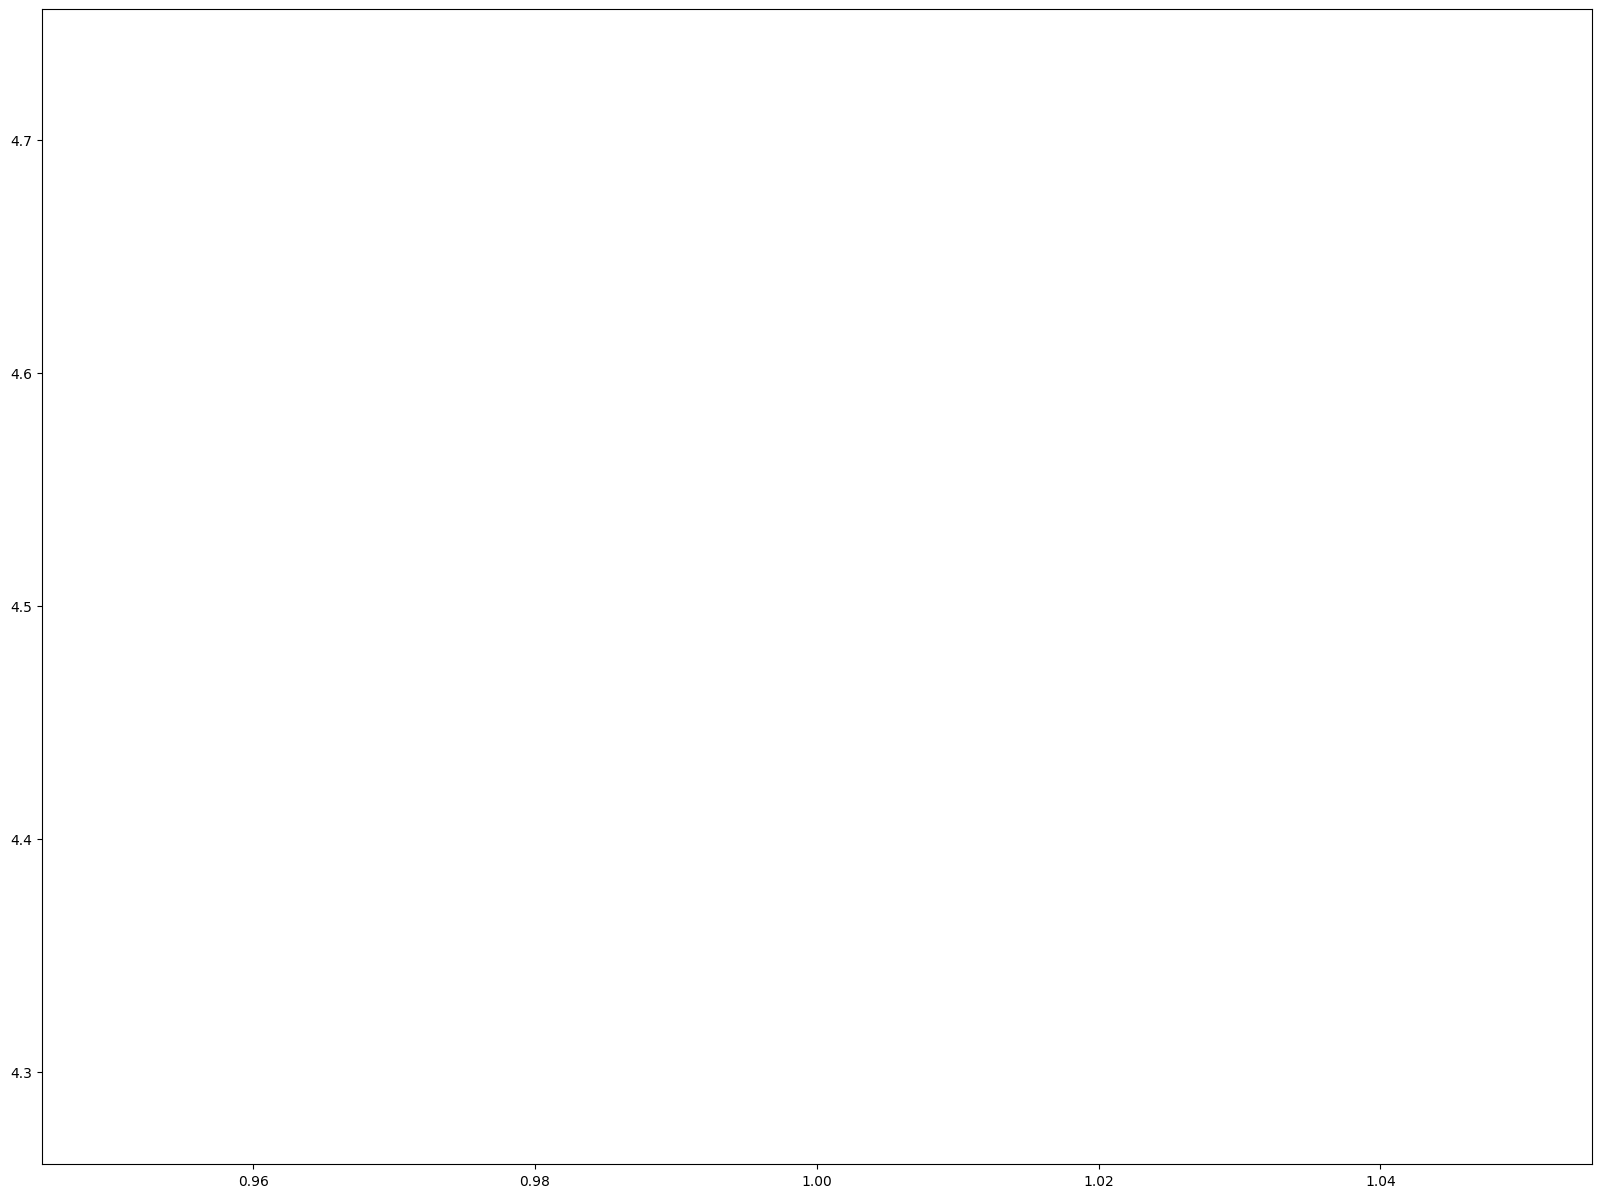

In [18]:
# Graph the model
x = np.array(np.ravel(X[:, -1]))
lobf = model.predict(X).flatten()

fig, ax = plt.subplots(figsize=(20,15))
ax.plot(x, lobf, color = "red", label='Prediction')
ax.plot(X[:, 1], Y, color = "blue", label='Traning Data')
ax.legend(loc=2)

In [5]:
# Calculate points along the line of best fit
data_points = np.asarray(data['Adj_Close'])

# Calculate the upper and lower pivot points relative to the line of best fit
# Upper/Lower pivots are the indecies of the data points that are the furthest from the line of best fit
upper_pivot = (data_points - lobf).argmax()
lower_pivot = (data_points - lobf).argmin()
print(upper_pivot, lower_pivot)

55 249


In [6]:
# Function to be optimized by gradient descent 
# Reference: https://github.com/neurotrader888/TrendLineAutomation/blob/main/trendline_automation.py
# Lines 6-24
def check_trend_line(upper, pivot, slope, y):
    # Find intercept of line going through pivot point
    intercept = -slope * pivot + y[pivot]
    line_values = slope * np.arange(len(y)) + intercept
    differences = line_values - y

    # Check to see if line is valid, if not return -1
    if upper and differences.max() > 1e-5:
        return -1.0
    elif not upper and differences.min() < -1e-5:
        return -1.0
    
    # Squared sum of differences between data and line
    error = (differences ** 2.0).sum()
    return error

# Sanity check
check_trend_line(True, lower_pivot, model.coef_[0][1], data_points)

-1.0

In [7]:
# TODO: Minimize the error function using gradient descent